<a href="https://colab.research.google.com/github/PiotrMaciejKowalski/BigData2024Project/blob/Szablon-wczytywania-danych-w-sparku/colabs/Wczytywanie_danych_NASA_w_sparku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wczytywanie danych w sparku

Utworzenie środowiska pyspark do obliczeń:

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

import findspark
findspark.init()

from pyspark.sql import SparkSession

from google.colab import drive

from pyspark.sql.types import IntegerType, FloatType, StringType, StructType

import pandas as pd

Utworzenie sesji:

In [ ]:
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '10g'), ('spark.driver.memory','10g')])
spark.conf.set("park.driver.maxResultSize", "12g")



Połączenie z dyskiem:

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Wczytanie danych NASA znajdujących się na dysku w sparku:

In [ ]:
# Wczytanie zbioru sampled w celu pobrania nazw kolumn
sampled = pd.read_csv('/content/drive/MyDrive/BigMess/NASA/sampled_NASA_200k.csv')

# Utworzenie schematu określającego typ zmiennych
schemat = StructType()
for i in sampled.columns:
  if i == "Date":
    schemat = schemat.add(i, StringType(), True)
  else:
    schemat = schemat.add(i, FloatType(), True)

In [164]:
# Wczytanie zbioru Nasa w sparku
nasa = spark.read.format('csv').option("header", True).schema(schemat).load('/content/drive/MyDrive/BigMess/NASA/NASA.csv')
nasa.show(20)

+---------+-------+------+---------+---------+---------+----------+---------+---------+----------+---+-----+-----+---------+---+-----------+---+---------+---------+---+---------+--------+------------+-------------+--------------+---------------+------------+-------------+--------------+---------------+-------------+-------------+----------+------------+-------------+--------------+---------------+---------------+---------------+---------+----------+---------+----------+-------+------------+------------+------------+----------+----------+----------+-----------+---------+------------+---------+----------+----------+
|      lon|    lat|  Date|   SWdown|   LWdown|    SWnet|     LWnet|      Qle|       Qh|        Qg| Qf|Snowf|Rainf|     Evap| Qs|        Qsb|Qsm| AvgSurfT|   Albedo|SWE|SnowDepth|SnowFrac|SoilT_0_10cm|SoilT_10_40cm|SoilT_40_100cm|SoilT_100_200cm|SoilM_0_10cm|SoilM_10_40cm|SoilM_40_100cm|SoilM_100_200cm|SoilM_0_100cm|SoilM_0_200cm| RootMoist|SMLiq_0_10cm|SMLiq_10_40cm|SMLiq_40_

Zanim zacznimy pisać kwerendy należy jeszcze dodać nasz DataFrame (df) do "przestrzeni nazw tabel" Sparka:

In [ ]:
nasa.createOrReplaceTempView("nasa")

Rodzielenie kolumny "Date" na kolumny "Year" oraz "Month"

In [ ]:
nasa = spark.sql("""
          SELECT
          CAST(SUBSTRING(CAST(Date AS STRING), 1, 4) AS INT) AS Year,
          CAST(SUBSTRING(CAST(Date AS STRING), 5, 2) AS INT) AS Month,
          n.*
          FROM nasa n
          """)

In [ ]:
nasa = nasa.drop("Date")
nasa.show(5)

+----+-----+---------+-------+---------+---------+---------+---------+---------+---------+----------+---+-----+-----+---------+---+----------+---+---------+---------+---+---------+--------+------------+-------------+--------------+---------------+------------+-------------+--------------+---------------+-------------+-------------+----------+------------+-------------+--------------+---------------+---------------+---------------+---------+----------+---------+----------+-------+------------+-----------+------------+----------+----------+----------+----------+---------+------------+---------+----------+----------+
|Year|Month|      lon|    lat|   SWdown|   LWdown|    SWnet|    LWnet|      Qle|       Qh|        Qg| Qf|Snowf|Rainf|     Evap| Qs|       Qsb|Qsm| AvgSurfT|   Albedo|SWE|SnowDepth|SnowFrac|SoilT_0_10cm|SoilT_10_40cm|SoilT_40_100cm|SoilT_100_200cm|SoilM_0_10cm|SoilM_10_40cm|SoilM_40_100cm|SoilM_100_200cm|SoilM_0_100cm|SoilM_0_200cm| RootMoist|SMLiq_0_10cm|SMLiq_10_40cm|SMLiq_4

#Wyodrębnienie zbiorów testowych i treningowych

**1. Zbiór testowy i treningowy dla problemu predykcji procesu pustynnienia**

In [ ]:
from pyspark.sql.functions import max, col

In [ ]:
%%time
last_year = nasa.select(max(col('Year'))).collect()


CPU times: user 1.19 s, sys: 149 ms, total: 1.34 s
Wall time: 3min 50s


In [ ]:
last = last_year[0].__getitem__('max(Year)')

In [ ]:
test_set = nasa.where(nasa.Year >= last-1)

In [ ]:
%%time
test_set.show(7)

+----+-----+---------+-------+--------+--------+--------+---------+--------+--------+---------+---+-----+-----+--------+---+---------+---+--------+--------+---+---------+--------+------------+-------------+--------------+---------------+------------+-------------+--------------+---------------+-------------+-------------+---------+------------+-------------+--------------+---------------+---------------+---------------+--------+---------+--------+--------+-------+----------+-----------+-----------+---------+---------+---------+---------+-----+------+--------+---------+----------+
|Year|Month|      lon|    lat|  SWdown|  LWdown|   SWnet|    LWnet|     Qle|      Qh|       Qg| Qf|Snowf|Rainf|    Evap| Qs|      Qsb|Qsm|AvgSurfT|  Albedo|SWE|SnowDepth|SnowFrac|SoilT_0_10cm|SoilT_10_40cm|SoilT_40_100cm|SoilT_100_200cm|SoilM_0_10cm|SoilM_10_40cm|SoilM_40_100cm|SoilM_100_200cm|SoilM_0_100cm|SoilM_0_200cm|RootMoist|SMLiq_0_10cm|SMLiq_10_40cm|SMLiq_40_100cm|SMLiq_100_200cm|SMAvail_0_100cm|SMAvai

In [ ]:
spark.conf.set('spark.sql.execution.arrow.enabled', 'true')

test_set_pandas = test_set.toPandas()

In [ ]:
%%time
train_set = nasa.where(nasa.Year < last-1)
train_set.show(10)

+----+-----+---------+-------+---------+---------+---------+----------+---------+---------+----------+---+-----+-----+---------+---+-----------+---+---------+---------+---+---------+--------+------------+-------------+--------------+---------------+------------+-------------+--------------+---------------+-------------+-------------+----------+------------+-------------+--------------+---------------+---------------+---------------+---------+----------+---------+----------+-------+------------+------------+------------+----------+----------+----------+----------+---------+------------+---------+----------+----------+
|Year|Month|      lon|    lat|   SWdown|   LWdown|    SWnet|     LWnet|      Qle|       Qh|        Qg| Qf|Snowf|Rainf|     Evap| Qs|        Qsb|Qsm| AvgSurfT|   Albedo|SWE|SnowDepth|SnowFrac|SoilT_0_10cm|SoilT_10_40cm|SoilT_40_100cm|SoilT_100_200cm|SoilM_0_10cm|SoilM_10_40cm|SoilM_40_100cm|SoilM_100_200cm|SoilM_0_100cm|SoilM_0_200cm| RootMoist|SMLiq_0_10cm|SMLiq_10_40cm|SM

In [ ]:
%%time
train_set_pandas = train_set.toPandas()

/content/spark-3.5.0-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:198: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true, but has reached the error below and can not continue. Note that 'spark.sql.execution.arrow.pyspark.fallback.enabled' does not have an effect on failures in the middle of computation.
  An error occurred while calling o77.getResult.
: org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:98)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:94)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMetho

Py4JJavaError: ignored

**2. Zbiór testowy i treningowy dla problemu klasyfikacji (pustynia/nie-pustynia)**

Największe wyzwanie i zasadniczy problem stanowi tutaj autokorelacja przestrzenna (*spatial autocorrelation*) typowa dla danych przestrzennych, a w konsekwencji wybór zbioru testowego o możliwie niskiej zależności przestrzennej (*spatial dependency*) ze zbiorem treningowym, by nie dopuścić do *data leakage* danych ze zbioru treningowego do testowego.



In [ ]:
min_lat = 25.0625
max_lat = 52.9375
min_lon = -124.9375
max_lon = -67.0625

In [ ]:
%%time
coordinates = spark.sql("""SELECT DISTINCT lon, lat from nasa""").toPandas()


CPU times: user 917 ms, sys: 92.9 ms, total: 1.01 s
Wall time: 3min 8s


**Pierwsze podejście**: wybieramy prostokąt, bądź sumę prostokątów (kwadratów) stykających się wierzchołkami. Poniższy kod pozwala na wygenerowanie listy współrzędnych "wpadających" do zadanego prostokąta (należy podać współrzędne lewego dolnego wierzchołka i prawego górnego wierzchołka, jeśli boki prostokąta są równoległe do osi, a jeśli prostokąt posiada inną orientację, należy dodatkowo podać współrzędne trzeciego wierzchołka).

In [ ]:
import numpy as np

#Input format:
#lower_left_vertex = [longitude of the lower left vertex, latitude of the lower left vertex]
#upper_right_vertex = [longitude of upper right vertex , latitude of upper right vertex]
#orientation = True/False; True if the points are vertically or horizontally aligned
#if rectangle's sides are not parallel with axes then one more argument is required: lower_right (representing the coordinates of lower right vertex)

def get_rectangle_coordinates(lower_left_vertex, upper_right_vertex, orientation=True, lower_right=None):
    rect_coords = []   #coordinates inside the rectangle

    if orientation:

        lower_right_vertex = [upper_right_vertex[0], lower_left_vertex[1]]
        upper_left_vertex = [lower_left_vertex[0], upper_right_vertex[1]]

        for i in range(len(coordinates)):

           lon = coordinates.at[i, "lon"]
           lat = coordinates.at[i, "lat"]
           if (lon > lower_left_vertex[0])&(lon < upper_right_vertex[0]):
              if (lat > lower_right_vertex[1])&(lat < upper_right_vertex[1]):
                 rect_coords.append([lon, lat])
    else:

        AB = [lower_right[0]-lower_left_vertex[0], lower_right[1]-lower_left_vertex[1]]
        BC = [upper_right_vertex[0]-lower_right[0], upper_right_vertex[1]-lower_right[1]]

        for i in range(len(coordinates)):

           lon =coordinates.at[i, "lon"]
           lat =coordinates.at[i, "lat"]

           AM = [lon-lower_left_vertex[0], lat-lower_left_vertex[1]]
           BM = [lon-lower_right[0], lat-lower_right[1]]
           AM_AB = np.inner(AM, AB)
           AB_AB = np.inner(AB, AB)
           BC_BM = np.inner(BC, BM)
           BC_BC = np.inner(BC, BC)


           if all([(0<=AM_AB),(AM_AB <= AB_AB),(0<=BC_BM),(BC_BM<=BC_BC)]):
               rect_coords.append([lon, lat])


    return rect_coords

Pozostaje oszacować pole prostokąta (bądź sumy prostokątów), z którego/których powinien składać się zbiór testowy (w rachunkach uwzględniamy fakt, że około 7% powierzchni USA stanowią obszary wodne, dla których nie posiadamy obserwacji w naszym datasecie, oraz to, że obszar na szerokości geograficznej znajdującej się pomiędzy 25 a 30 stopniem, to zgrubsza w ponad 3/4 woda, a teren znajdujący się pomiędzy 30 a 40 stopniem szerokości oraz -80 a -67 stopniem długosci geograficznej, to mniej więcej w połowie woda):

In [ ]:
area = (max_lat-40)*(max_lon-min_lon)*0.93 + 0.20*(30-min_lat)*(max_lon-min_lon) + 0.5*(40-30)*(max_lon-(-80)) +0.93*(40-30)*(-80-min_lon)

block_area = 0.15*area
block_area


185.41538671875

In [ ]:
len(coordinates)*0.10  # approx. number of points in test set

7636.0

Poniżej wygenerowano przykładowy zbiór testowy. (Tworząc inne, należy zatroszczyć się o to, by w takim prostokącie/prostokątach znalazł się jakiś fragment terenu pustynnego).

Poglądowa grafika przedstawiająca obszar zbioru testowego:
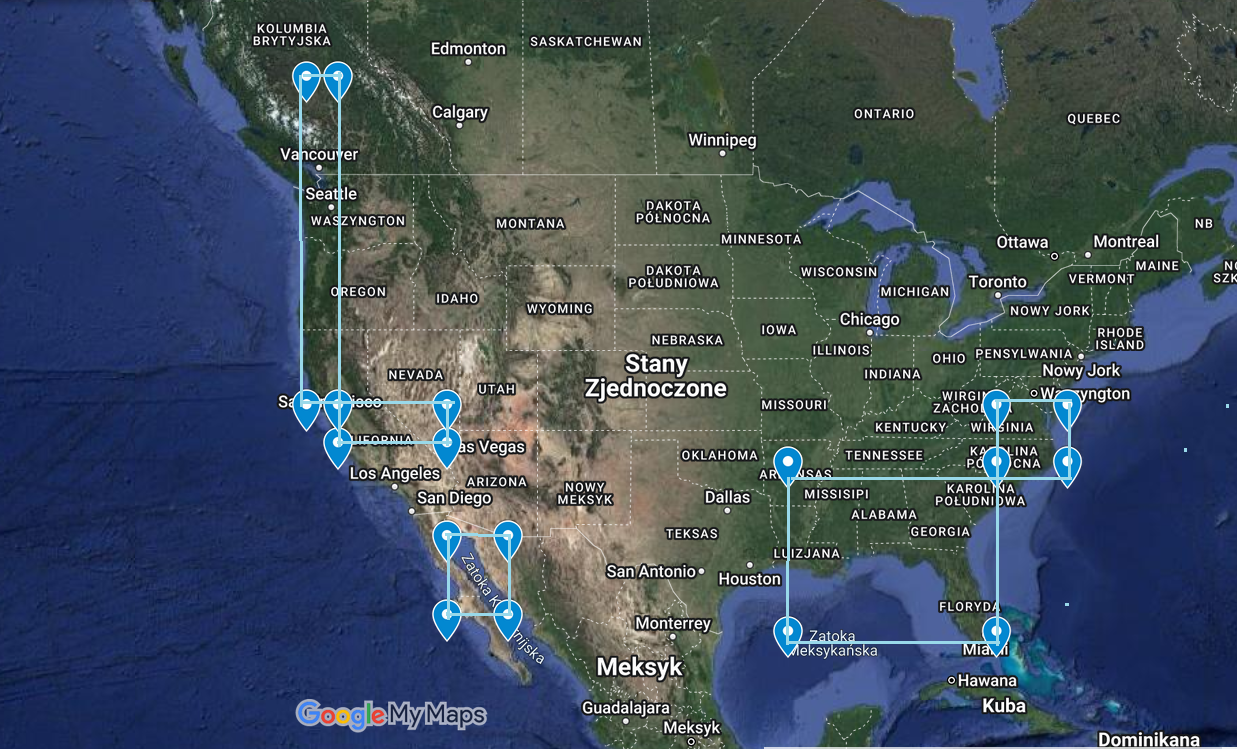

In [ ]:
rectangle1 = get_rectangle_coordinates([-122,25.5], [-115, 37], orientation=True)
rectangle2 = get_rectangle_coordinates([-124,37], [-122, 52], orientation=True)
rectangle3 = get_rectangle_coordinates([-93, 24.5], [-79.5, 34], orientation=True)
rectangle4 = get_rectangle_coordinates([-79.5, 34], [-75, 37], orientation=True)
rectangle5 = get_rectangle_coordinates([-115, 25.5], [-111, 30], orientation=True)

test_set_coordinates = rectangle1 + rectangle2 + rectangle3 + rectangle4 + rectangle5
len(test_set_coordinates)

8228

In [ ]:
train_set_coordinates = coordinates.values.tolist()
for t in  test_set_coordinates:
   train_set_coordinates.remove(t)

68132

In [169]:
test_set_coords = pd.DataFrame(test_set_coordinates, columns=['lon', 'lat'])
train_set_coords = pd.DataFrame(train_set_coordinates, columns=['lon', 'lat'])

In [174]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
test_df = spark.createDataFrame(test_set_coords)
train_df = spark.createDataFrame(train_set_coords)

In [178]:
cond = [train_df['lon'] == nasa['lon'], train_df['lat'] == nasa['lat']]
train_set = nasa.join(train_df, cond, 'inner').select(nasa['*']).show()

+---------+-------+------+---------+---------+---------+----------+---------+---------+----------+---+-----+-----+---------+---+-----------+---+---------+---------+---+---------+--------+------------+-------------+--------------+---------------+------------+-------------+--------------+---------------+-------------+-------------+----------+------------+-------------+--------------+---------------+---------------+---------------+---------+----------+---------+----------+-------+------------+------------+------------+----------+----------+----------+-----------+---------+------------+---------+----------+----------+
|      lon|    lat|  Date|   SWdown|   LWdown|    SWnet|     LWnet|      Qle|       Qh|        Qg| Qf|Snowf|Rainf|     Evap| Qs|        Qsb|Qsm| AvgSurfT|   Albedo|SWE|SnowDepth|SnowFrac|SoilT_0_10cm|SoilT_10_40cm|SoilT_40_100cm|SoilT_100_200cm|SoilM_0_10cm|SoilM_10_40cm|SoilM_40_100cm|SoilM_100_200cm|SoilM_0_100cm|SoilM_0_200cm| RootMoist|SMLiq_0_10cm|SMLiq_10_40cm|SMLiq_40_

In [175]:
cond = [test_df['lon'] == nasa['lon'], test_df['lat'] == nasa['lat']]
test_set = nasa.join(test_df, cond, 'inner').select(nasa['*']).show()

+---------+-------+------+---------+---------+---------+----------+---------+---------+-----------+---+-----+----------+---------+----------+-----------+---+---------+---------+---+---------+--------+------------+-------------+--------------+---------------+------------+-------------+--------------+---------------+-------------+-------------+---------+------------+-------------+--------------+---------------+---------------+---------------+---------+----------+---------+----------+-------+------------+------------+------------+----------+----------+----------+----------+---------+-----------+---------+----------+----------+
|      lon|    lat|  Date|   SWdown|   LWdown|    SWnet|     LWnet|      Qle|       Qh|         Qg| Qf|Snowf|     Rainf|     Evap|        Qs|        Qsb|Qsm| AvgSurfT|   Albedo|SWE|SnowDepth|SnowFrac|SoilT_0_10cm|SoilT_10_40cm|SoilT_40_100cm|SoilT_100_200cm|SoilM_0_10cm|SoilM_10_40cm|SoilM_40_100cm|SoilM_100_200cm|SoilM_0_100cm|SoilM_0_200cm|RootMoist|SMLiq_0_10cm|S

**Drugi wariant:**  spatial block cross-validation, którą możemy spróbować delikatnie zmodyfikować dodając za każdym razem do *foldu* testowego uprzednio "wycięty" fragment pustyni (być może *Baja California*?)

Poniższy kod dzieli współrzędne na kwadratowe bloki (generuje grid) o zadanej wielkości:

In [68]:
import math

#grid_cell_size - the grid cell size (the length of the side of a square) in degrees
def get_grid(grid_cell_size):

 min_lat = 25.0625
 max_lat = 52.9375
 min_lon = -124.9375
 max_lon = -67.0625

 area = (max_lat-min_lat)*(max_lon-min_lon)
 cells_num = area//(grid_cell_size*grid_cell_size)
 actual_grid_size = math.sqrt(area/cells_num)

 xx=np.arange(min_lon, max_lon, step = actual_grid_size)
 yy=np.arange(min_lat, max_lat, step = actual_grid_size)
 #xx, yy = np.meshgrid(x,y, sparse=True)

 return(xx, yy)


#coordinates: pandas DataFrame with "lon" and "lat" columns containing coordinates
#block_size: approximate size of a block
def block_partition(coordinates, block_size):

  coords = coordinates
  blocks = []
  xx, yy = get_grid(block_size)

  for y in range(len(yy)-1):
      for x in range(len(xx)-1):
          block = []
          for c in coords.index:
               lon = coords.at[c,'lon']
               lat = coords.at[c, 'lat']
               if (lon >= xx[x])&(lon <= xx[x+1]):
                   if (lat >= yy[y])&(lat < yy[y+1]):
                       block.append([lon, lat])
                       coords = coords.drop(index=c)
          if len(block)>0:        #checking if block is nonempty (it is possible because coordinates coresponding to water areas are missing)
             blocks.append(block)


  return(blocks)



Wycinamy wspomniany wcześniej fragment terenu pustynnego:

In [ ]:
block_with_desert = get_rectangle_coordinates([-115, 25.5], [-111, 31])   #block containing desert, to be removed from dataset before generating blocks and added to test fold afterwards

coordinates2 = coordinates.values.tolist()
for b in block_with_desert:
  coordinates2.remove(b)

coordinates2 = pd.DataFrame(coordinates2, columns=['lon', 'lat'])  #coordinates from dataset without coordinates from block_with_desert


75685

Funkcja generująca podział na foldy:

In [79]:
import random

#k - number of folds
#blocks - list of list of blocks' coordinates
def Kfolds(k, blocks):

    n = len(blocks)//k
    reminder = len(blocks)%k
    folds=[]

    for i in range(k):
          fold = []
          for j in range(n):
                r = random.randint(0, len(blocks)-1)
                fold.append(blocks[r])
                blocks.remove(blocks[r])
          folds.append(fold)

    if reminder!=0:
       for b in blocks:
           n_fol = random.randint(0, k)
           folds[n_fol].append(b)

    return(folds)

Dla przykładu wygenerujemy foldy dla k = 6 oraz block_size = 2:

In [80]:
blocks =  block_partition(coordinates2, block_size=2)
folds = Kfolds(6, blocks)

Następnie za każdym razem należy do foldu testowego dodawać wygenerowany powyżej *block_with_desert*